# 2D, periodic lake drainage 

## Problem description

A supraglacial lake fills at a specified rate, inducing deflections, until accumulated curvature reaches some threshold value. At this point, the lake drains until the accumulated curvature falls below the failure limit, and then the lake begins to fill again. This produces a periodic fill-drain cycle. 

In [1]:
nx, ny = 200, 200 #grid resolution
T = 273.15 - 0 #temperature (K); freezing is 273.15
κ_c = 1e-5 #critical stress threshold for plastic deflection
H_gl = 100
u_gl = 1000
Δt = 1/365/20
num_years = 30/365 #choose how many years to model
valve_thresh = 1e-6 #once damage reaches this threshold, the lake begins to drain
K = 1e6 #the scalar multiple used to weight γ

fill_rate = 1/10*365 #filling rate of the pond in meters per year
drain_rate = fill_rate*100 #drainage rate of the pond (m/yr)

saved_arrays_path = '/home/firedrake/H3F/numpy_arrays/' #the path where any existing steady-state flow solutions have already been saved
transport_solver_path = '/home/firedrake/H3F/notebooks/flow/' #where the "transport_solver" module can be imported from
figures_path = '/home/firedrake/H3F/figures/2D_lake_drainage/' #where figures will be saved

## Imports

In [2]:
%%capture

from firedrake import *
import icepack
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
norm = colors.TwoSlopeNorm(vcenter = 0)
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from operator import itemgetter
import os
import tqdm

!pip install import_ipynb #this block is to allow importing transport_solver, which is not yet a part of icepack
import import_ipynb
os.chdir(transport_solver_path) #location of the transport solver notebook
from transport_solver import TransportEquation, TransportSolver

## Material parameters

In [3]:
ρ_i = 917 #density of ice (kg/m^3)
ρ_w = 1024 #density of seawater
ϱ = ρ_i/ρ_w #density ratio
g = 9.81 #gravitational constant (N/kg)
year = icepack.constants.year #number of seconds in a year
A = icepack.rate_factor(Constant(T)) 

## Meshing 

In [4]:
nx, ny = nx, ny #number of nodes
Lx, Ly = 8000, 8000 #length of domain
mesh = RectangleMesh(nx, ny, Lx, Ly, name = f'my_mesh_{nx}_{T}_{u_gl}') #identify mesh by resolution and temperature

num_timesteps = int(num_years/Δt) + 1 #number of timesteps
deg = 1

Q = FunctionSpace(mesh, 'CG', deg)
S = TensorFunctionSpace(mesh, 'CG', deg)
QS = Q*S #mixed function space for (η, κ)

q = Function(QS)
η_dot, κ_dot = split(q) #trial functions for the deflection or rate and moment
n_dot, k = TestFunctions(QS) #test functions
Δη = Function(Q) #empty function to hold each step's deflection update
κ = Function(S)
η = Function(Q) #and the previous net deflection from the previous timestep
κ_p = Function(S)
γ = Function(Q)

V = VectorFunctionSpace(mesh, 'CG', deg)
u_trial = TrialFunction(V) #trial function for the velocity
v = TestFunction(V) #test function for velocity

x, y = SpatialCoordinate(mesh)
X = np.arange(0, Lx, 1) #for plotting longitudinal profiles
X = np.array([(k, Ly/2) for k in X])

## Initialize SSA solver

In [5]:
#####################################
######################################
### initialize values to be solved ###
######################################
######################################

os.chdir(saved_arrays_path) #location of the transport solver notebook

H_0 = Function(Q).project(Constant(H_gl)) #initial thickness
s_0 = Function(Q).project((1 - ϱ)*H_0) #initial surface elevation

ρ_I, ρ_W = ρ_i/1e6/year**2, ρ_w/1e6/year**2 #put into icepackese
G = g*year**2

def gravity(**kwargs): #see RHS of Eq. 44 in MacAyeal et al. (2021)
    u, H, s = itemgetter('velocity', 'thickness', 'surface')(kwargs)
    return -0.5* ρ_I*G*inner(grad(H**2), u) + 0.5*ρ_W*G*inner(grad((s - H)**2), u)

def terminus(**kwargs): #see Eq. 45 from MacAyeal et al. (2021)
    u, H, s = itemgetter('velocity', 'thickness', 'surface')(kwargs)
    mesh = u.ufl_domain()
    ν = FacetNormal(mesh)
    return 0.5*ρ_I*G*H**2*inner(u, ν) - 0.5*ρ_W*G*(s - H)**2*inner(u, ν)

from icepack.constants import glen_flow_law as n
# from icepack.models.viscosity import viscosity_depth_averaged

def effective_viscosity(**kwargs): #also define a function that returns the effective viscosity
    flow_n = 3
    u = itemgetter('velocity')(kwargs)
    ε = sym(grad(u))
    ε_min = Constant(kwargs.get('strain_rate_min', icepack.constants.strain_rate_min))
    ε_e = icepack.models.viscosity._effective_strain_rate(ε, ε_min)
    ν = 1/2*A**(-1/flow_n)*ε_e**(1/flow_n - 1) #effective viscosity in MPa*yrs
    return ν*1e6 #return ν in units of Pa*yrs

opts = {
    'dirichlet_ids': [1], #boundaries are labeled (1, 2, 3, 4) = (upstream, downstream, left, right)
    'side_wall_ids': [3, 4],
    'ice_front_ids': [2],
    # 'diagnostic_solver_type': 'petsc',
    # 'diagnostic_solver_parameters': {
    #     'ksp_type': 'cg',
    #     'pc_type': 'mg',
    #     'pc_mg_cycle_type': 'w',
    #     'snes_line_search_type': 'cp',
    # },
    'prognostic_solver_parameters': {
        'ksp_type': 'gmres',
        'pc_type': 'ilu',
    },
}

flow_model = icepack.models.IceShelf(gravity = gravity, terminus = terminus) #model is icepack's SSA, but with our own physics
flow_solver = icepack.solvers.FlowSolver(flow_model, **opts)

## Spin up to steady state (or load saved geometry)

In [6]:
try: #load stead state velocity and thickness profile, if this has already been saved:
    
    with CheckpointFile(f"checkpoint_file_{nx}_{T}_{u_gl}.h5", 'r') as afile:
        mesh = afile.load_mesh(f'my_mesh_{nx}_{T}_{u_gl}')
        s_0 = afile.load_function(mesh, f'surface_{nx}_{T}_{u_gl}')
        H_0 = afile.load_function(mesh, f'thickness_{nx}_{T}_{u_gl}')
        u_0 = afile.load_function(mesh, f'velocity_{nx}_{T}_{u_gl}')

    s_0 = Function(Q).project(s_0)
    H_0 = Function(Q).project(H_0)
    u_0 = Function(V).project(u_0)
    
    u_0 = flow_solver.diagnostic_solve(velocity = u_0, side_friction = friction, 
                                     thickness = H_0, surface = s_0, fluidity = Constant(A))
    
    b_0 = Function(Q).project(-ϱ*H_0) #initial basal elevation
    
except:

###############################
###############################
### spin up to steady state ###
###############################
###############################

    residence_time = 5*int(Lx/u_gl) #estimated number of years for grounding line ice to reach the terminus
    dt = 1/10 #set the timestep to one tenth of a year
    u_0 = Function(V).project(as_vector((u_gl, 1e-50)))
    
    for step in tqdm.trange(int(residence_time/dt)):
        
        u_0 = flow_solver.diagnostic_solve(velocity = u_0, side_friction = Constant(0),
                                         thickness = H_0, surface = s_0, fluidity = Constant(A))
        H_0 = flow_solver.prognostic_solve(dt, thickness = H_0, velocity = u_0,
                                         thickness_inflow = H_0, accumulation = Constant(0))
        s_0 = Function(Q).project((1 - ϱ)*H_0) #initial surface elevation
    
    s_0 = Function(Q, name = f'surface_{nx}_{T}_{u_gl}').project(s_0)
    H_0 = Function(Q, name = f'thickness_{nx}_{T}_{u_gl}').project(H_0)
    u_0 = Function(V, name = f'velocity_{nx}_{T}_{u_gl}').project(u_0)
    b_0 = Function(Q).project(-ϱ*H_0) #initial basal elevation

    with CheckpointFile(f'checkpoint_file_{nx}_{T}_{u_gl}.h5', 'w') as afile:
        afile.save_mesh(mesh)  # optional
        afile.save_function(s_0)
        afile.save_function(H_0)
        afile.save_function(u_0)

100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [02:38<00:00,  2.52it/s]


## Plot the initial steady-state geometry

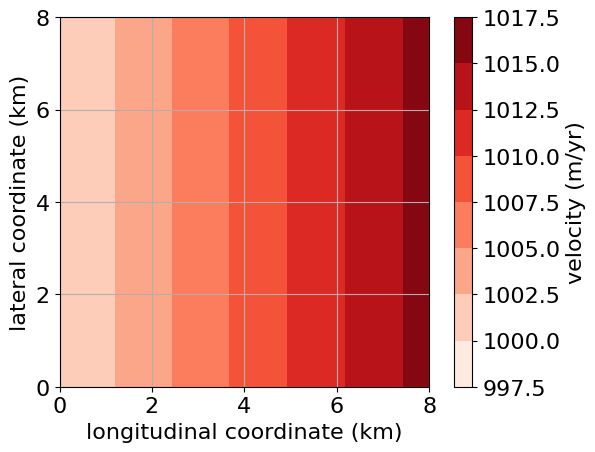

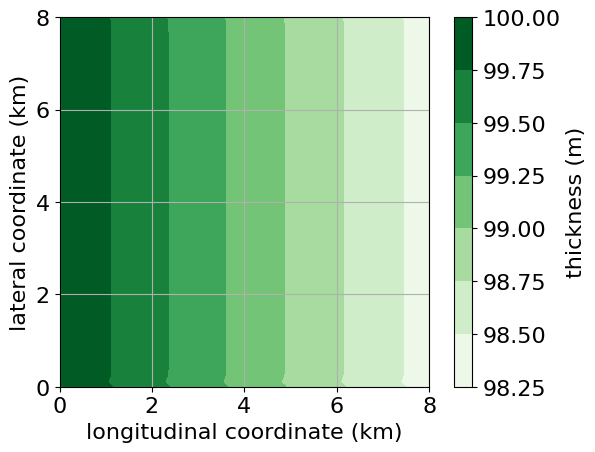

In [7]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
plot = tricontourf(u_0, axes = ax, cmap = 'Reds')#, vmin = 30, vmax = 100)
cbar = plt.colorbar(plot)
cbar.ax.tick_params(labelsize=16)  # Adjust tick font size
cbar.set_label('velocity (m/yr)', fontsize=16) 
plt.xticks(range(0, Lx + 1, 2000), range(0, int(Lx/1000) + 1, 2), fontsize = 16)
plt.yticks(range(0, Ly + 1, 2000), range(0, int(Ly/1000) + 1, 2), fontsize = 16) 
plt.xlabel('longitudinal coordinate (km)', fontsize = 16)
plt.ylabel('lateral coordinate (km)', fontsize = 16)
plt.grid()
plt.show()

fig, ax = plt.subplots()
ax.set_aspect('equal')
plot = tricontourf(H_0, axes = ax, cmap = 'Greens')#, vmin = 30, vmax = 100)
cbar = plt.colorbar(plot)
cbar.ax.tick_params(labelsize = 16)  # Adjust tick font size
cbar.set_label('thickness (m)', fontsize=16) 
plt.xticks(range(0, Lx + 1, 2000), range(0, int(Lx/1000) + 1, 2), fontsize = 16)
plt.yticks(range(0, Ly + 1, 2000), range(0, int(Ly/1000) + 1, 2), fontsize = 16) 
plt.xlabel('longitudinal coordinate (km)', fontsize = 16)
plt.ylabel('lateral coordinate (km)', fontsize = 16)
plt.grid()
plt.show()

## Add a gaussian surface depression

In [8]:
r_1 = 2000 #radius of the depressions
amp_1 = 1/2 #amplitude of the depressions
px_1 = Lx/2 #center coordinates of the depressions
py_1 = Ly/2

D_1 = conditional(
    sqrt((x - px_1)**2 + (y - py_1)**2) < r_1,  # Check if within the radius
    1/2 * amp_1 * cos(pi * sqrt((x - px_1)**2 + (y - py_1)**2) / r_1) + 1/2 * amp_1,  # Gaussian function
    0  # Zero outside the radius
)

s_0 = project((1 - ϱ)*H_0 - D_1, Q) #correct the initial surface topography for the depresion...
H_0 = project(s_0/(1 - ϱ), Q) #...but keep the shelf in equilibrium initially
b_0 = project(s_0 - H_0, Q)

w_1 = Function(Q).project(Constant(s_0.at((px_1, py_1), tolerance = 1e-10))) #water height in the first lake
d_1 = Function(Q).project(max_value(w_1 - s_0, 0)) #water depth in the first lake

## Initialize remaining solvers

In [9]:
####################################
####################################
### initialize remaining solvers ###
####################################
####################################

nonconservative_transport_model = TransportEquation(field_name = 'field', conservative = False) #for nonconservative advection
nonconservative_transport_solver = TransportSolver(nonconservative_transport_model, **opts) #e.g., η, eventually damage

H = H_0.copy(deepcopy = True)
s = s_0.copy(deepcopy = True)
b = b_0.copy(deepcopy = True)
u = u_0.copy(deepcopy = True)

path = figures_path + f'H-{H_gl}_u-{u_gl}_T-{T}_nx-{nx}_kappa-{κ_c}_thresh-{valve_thresh}_fill_rate-{fill_rate}_drain_rate-{drain_rate}'

try:
    os.chdir(path)
except:
    os.mkdir(path)
    os.chdir(path)

In [10]:
os.getcwd()

'/home/firedrake/H3F/figures/2D_lake_drainage/H-100_u-1000_T-273.15_nx-200_kappa-1e-05_thresh-1e-06_fill_rate-36.5_drain_rate-3650.0'

## Solve with firedrake 

In [11]:
max_depth, max_γ, drain_time = [], [], []
η_profile, κ_profile, d_profile = [], [], []
filling = True
draining = False

for step in tqdm.trange(num_timesteps):

    #########################
    #########################
    ### obtain flow field ###
    #########################
    #########################
        
    u = flow_solver.diagnostic_solve(velocity = u, side_friction = Constant(0), 
                             thickness = H, surface = s)
    b = flow_solver.prognostic_solve(Δt, thickness = b, velocity = u,
                                     thickness_inflow = b_0, accumulation = Constant(0))
    s = flow_solver.prognostic_solve(Δt, thickness = s, velocity = u,
                                     thickness_inflow = s_0, accumulation = Constant(0))     

    s = Function(Q).project(s)
    H = Function(Q).project(s - b) #initial basal elevation
        
    ε = Function(S).project(sym(grad(u))) #strain rate tensor
    ν = effective_viscosity(velocity = u) #effective viscosity
    τ = Function(S).project(2*ν*ε) #deviatoric stress tensor
    P = -tr(τ) + 1/2*ρ_i*g*H #depth-averaged pressure
    σ = τ - P*Identity(2) #depth-averaged net stress tensor
    
    h_ab = Function(Q).project(s - (1 - ρ_i/ρ_w)*H)
    ϱ = Function(Q).project(1 - s/H)

    C = Function(Q).project(1/6*ν*H**3)

    q = Function(QS)
    η_dot, κ_dot = split(q)
    

    ######################
    ######################
    ### flex the shelf ###
    ######################
    ######################
    
    term_ids = [2]
    inflow_ids = [1]
    sidewall_ids = [3, 4]
    
    κ_term = DirichletBC(QS.sub(1), 0*Identity(2), term_ids)
    κ_gl = DirichletBC(QS.sub(1), 0*Identity(2), inflow_ids)
    η_gl = DirichletBC(QS.sub(0), 0, inflow_ids)
    η_sides = DirichletBC(QS.sub(0), 0, sidewall_ids)
    η_term = DirichletBC(QS.sub(0), 0, term_ids)
    

    J_II = sqrt(1/2*(κ_dot[0, 0]**2 + κ_dot[1, 1]**2 + κ_dot[0, 1]**2 + κ_dot[1, 0]**2)) #J_II of κ_dot
    β = 1/2
    α = conditional(J_II > κ_c, (κ_c + β*(J_II - κ_c))/J_II, 1)
    
    a = dot(div(C*κ_dot + C*tr(κ_dot)*Identity(2)), grad(n_dot))*dx - n_dot*ρ_w*g*η_dot*Δt*dx - dot(grad(η_dot*Δt), div(n_dot*H*σ))*dx   
    a += α*inner(ν*κ_dot, k)*dx + dot(grad(η_dot), div(ν*k))*dx
    L = n_dot*ρ_w*g*(h_ab)*dx + n_dot*1000*g*max_value(d_1, 0)*dx + dot(grad(η), div(n_dot*H*σ))*dx 

    solve(a - L == 0, q, bcs = [η_gl, κ_gl, η_term, κ_term])


    Δη.project(η_dot*Δt)
    η.project(η + Δη)
    Δκ = κ_dot*Δt
    κ = Function(S).project(κ + Δκ)
    κ_p = Function(S).project(κ_p + (α - 1)*Δκ)
    
    κ_xx, κ_xy, κ_yy = Function(Q).project(κ[0, 0]), Function(Q).project(1/2*(κ[0, 1] + κ[1, 0])), Function(Q).project(κ[1, 1])
    κp_xx, κp_xy, κp_yy = Function(Q).project(κ_p[0, 0]), Function(Q).project(1/2*(κ_p[0, 1] + κ_p[1, 0])), Function(Q).project(κ_p[1, 1])
    
    s = Function(Q).project(s + Δη)
    b = Function(Q).project(b + Δη)

    #############################
    #############################
    ### update the lake level ###
    #############################
    #############################
    
    u_1 = u.at((px_1, py_1), tolerance = 1e-10)
    px_1 = px_1 + u_1[0]*Δt #center of the lake
    py_1 = py_1 + u_1[1]*Δt

    day_number = int(step*Δt*365)
    if filling:
        w_1 = Function(Q).project(w_1 + fill_rate*Δt + Δη.at((px_1, py_1), tolerance = 1e-10))
        d_1 = Function(Q).project(max_value(w_1 - s, 0)*conditional(sqrt((x - px_1)**2 + (y - py_1)**2) < r_1, 1, 0))
    elif draining:
        w_1 = Function(Q).project(w_1 + Δη.at((px_1, py_1), tolerance = 1e-10) - drain_rate*Δt)
        d_1 = Function(Q).project(max_value(w_1 - s, 0)*conditional(sqrt((x - px_1)**2 + (y - py_1)**2) < r_1, 1, 0))
        drain_time.append(step)
        if max(d_1.dat.data) < 1e-5:
            w_1 = Function(Q).project(Constant(s.at((px_1, py_1), tolerance = 1e-10)))
            d_1 = Function(Q).project(Constant(0))

    η = Function(Q).project(nonconservative_transport_solver.prognostic_solve(Δt, field = η, velocity = u, field_inflow = η,
                                                               field_accumulation = Constant(0)))
    κ_xx = nonconservative_transport_solver.prognostic_solve(Δt, field = κ_xx, velocity = u, field_inflow = κ_xx,
                                                                                  field_accumulation = Constant(0))
    κ_xy = nonconservative_transport_solver.prognostic_solve(Δt, field = κ_xy, velocity = u, field_inflow = κ_xy,
                                                                                  field_accumulation = Constant(0))
    κ_yy = nonconservative_transport_solver.prognostic_solve(Δt, field = κ_yy, velocity = u, field_inflow = κ_yy,
                                                                                  field_accumulation = Constant(0))
    κp_xx = nonconservative_transport_solver.prognostic_solve(Δt, field = κp_xx, velocity = u, field_inflow = κp_xx,
                                                                                  field_accumulation = Constant(0))
    κp_xy = nonconservative_transport_solver.prognostic_solve(Δt, field = κp_xy, velocity = u, field_inflow = κp_xy,
                                                                                  field_accumulation = Constant(0))
    κp_yy = nonconservative_transport_solver.prognostic_solve(Δt, field = κp_yy, velocity = u, field_inflow = κp_yy,
                                                                                  field_accumulation = Constant(0))
                                                            
    κ.project(as_tensor([[κ_xx, κ_xy], [κ_xy, κ_yy]]))
    κ_p.project(as_tensor([[κp_xx, κp_xy], [κp_xy, κp_yy]]))
    γ = Function(Q).project(sqrt(1/2*(κ_p[0, 0]**2 + κ_p[1, 1]**2 + κ_p[0, 1]**2 + κ_p[1, 0]**2)))

    γ_forcing = Function(Q).project(conditional(sqrt((x - px_1)**2 + (y - py_1)**2) < r_1, γ, 0)) #the values of δ that actually produce drainage - i.e., over the lake
    valve_forcing = max(γ_forcing.dat.data)
    if valve_forcing > valve_thresh:
        filling = False
        draining = True
    else:
        filling = True
        draining = False

    γ = Function(Q).project(K*γ)
    effective_surface = Function(Q).project(s + d_1)
    max_depth.append(max(d_1.dat.data))
    max_γ.append(valve_forcing)
    η_profile.append(η.at(X, tolerance = 1e-10))
    κ_profile.append(γ.at(X, tolerance = 1e-10))
    d_profile.append(d_1.at(X, tolerance = 1e-10))

    ###############
    ###############
    ### figures ###
    ###############
    ###############
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={'wspace': 0.2})
    plots = [(η, 'seismic', -0.5, 0.5, r'$\eta$ (m)'),
             (γ, 'Greens', 0, K * valve_thresh, r'$\gamma$')]
    for ax, (data, cmap, vmin, vmax, title) in zip(axes, plots):
        ax.set_aspect('equal')
        plot = tripcolor(data, axes=ax, cmap=cmap, vmin=vmin, vmax=vmax)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(plot, cax=cax)
        cbar.ax.tick_params(labelsize=14, direction='out')
        ax.set_xticks(range(0, Lx + 1, 2000))
        ax.set_xticklabels(range(0, int(Lx / 1000) + 1, 2), fontsize=10)
        ax.set_xlabel('$x$ (km)', fontsize=14)
        ax.set_title(f'{title}, $t$ = {365 * step * Δt:.2f} days', fontsize=14)
        ax.grid()
    axes[0].set_yticks([])  # Remove y-ticks from the left plot
    axes[1].set_yticks(range(0, Ly + 1, 2000))
    axes[1].set_yticklabels(range(0, int(Ly / 1000) + 1, 2), fontsize=10)
    axes[1].yaxis.tick_left()
    axes[1].yaxis.set_label_position("left")
    fig.text(0.04, 0.5, '$y$ (km)', va='center', ha='center', fontsize=14, rotation=90)
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2)
    plt.savefig(f'η_γ_{step}.png')
    plt.close()

    line = Function(Q).project(s + d_1).at(X, tolerance = 1e-10)
    plt.figure()
    plt.plot(line, color = 'b', label = 'water level')
    plt.plot(s.at(X, tolerance = 1e-10), color = 'k', label = 'ice surface')
    plt.xticks(range(0, Lx + 1, 2000), range(0, int(Lx/1000) + 1, 2), fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.xlabel('longitudinal coordinate (km)', fontsize = 16)
    plt.ylabel('elevation (m)', fontsize = 16)
    plt.ylim(9, 11)
    plt.legend(fontsize = 16)
    plt.grid()
    plt.title(f'$t$ = {365*step*Δt:.2f} days', fontsize = 16)
    plt.tight_layout()
    plt.savefig(f'surface_{step}')
    plt.close()

100%|███████████████████████████████████████████████████████████████████████████████| 601/601 [4:09:13<00:00, 24.88s/it]


# Plot results

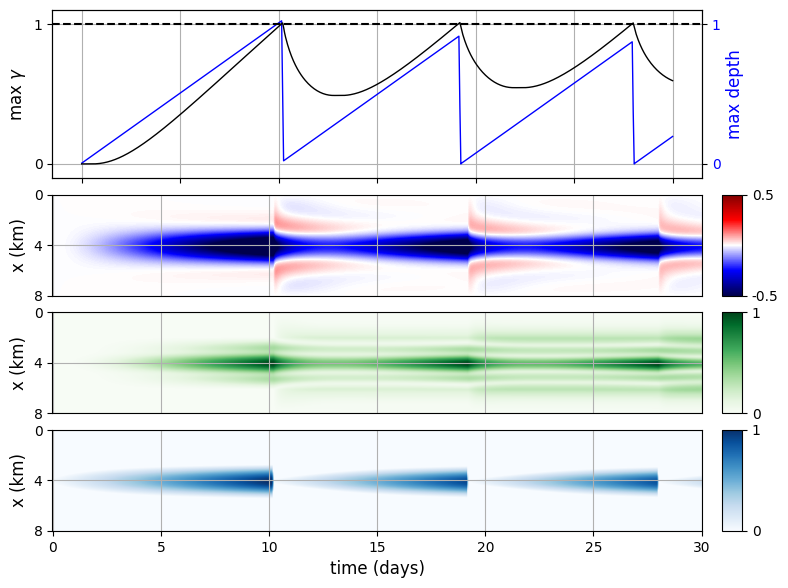

In [14]:
# Define global font size variables
fontsize = 12
fontsize_ticks = 10

# Create figure
fig = plt.figure(figsize=(10, 5.6))

density = 1

# Expand profiles efficiently
η_profile_expanded = np.repeat(np.array(η_profile), density, axis=0).T
κ_profile_expanded = np.repeat(np.array(κ_profile), density, axis=0).T
d_profile_expanded = np.repeat(np.array(d_profile), density, axis=0).T

### **Manually Adjusted Subplot Positions (Shift Up)**

top_subplot_height = 0.30  # Keep top at 0.95
small_subplot_height = 0.18  # Keep these unchanged

ax4 = fig.add_axes([0.1, 0.67, 0.65, top_subplot_height])  # Shifted up
ax1 = fig.add_axes([0.1, 0.46, 0.65, small_subplot_height])  # Shifted up
ax2 = fig.add_axes([0.1, 0.25, 0.65, small_subplot_height])  # Shifted up
ax3 = fig.add_axes([0.1, 0.04, 0.65, small_subplot_height])  # Shifted up

####### **TOP PLOT (LINE PLOT)** #######
ax4.plot(max_depth, color='blue', linewidth=1, label='depth')
ax4.set_ylabel('max $\gamma$', fontsize=fontsize, color='black')
ax4.set_ylim(-0.1, 1.1)
ax4.grid()

ax5 = ax4.twinx()
ax5.plot([entry * 1e6 for entry in max_γ], color='k', linewidth=1, linestyle='solid', label='curvature')
ax5.axhline(valve_thresh * 1e6, color='k', linestyle='dashed', label='threshold value')

ax5.set_ylabel('max depth', fontsize=fontsize, color='blue')
ax5.set_ylim(-0.1, 1.1)

# **Ensure y-ticks only appear at 0 and 1 for both y-axes (ax4 and ax5)**
ax4.set_yticks([0, 1])
ax4.set_yticklabels(["0", "1"], fontsize=fontsize_ticks)

ax5.set_yticks([0, 1])
ax5.set_yticklabels(["0", "1"], fontsize=fontsize_ticks, color='blue')

####### **IMAGE PLOTS** #######

for ax, data, cmap, cbar_pos, cbar_ticks in zip(
    [ax1, ax2, ax3],
    [η_profile_expanded, κ_profile_expanded, d_profile_expanded],
    ['seismic', 'Greens', 'Blues'],
    [0.46, 0.25, 0.04],  # Shifted colorbars accordingly
    [[-0.5, 0.5], [0, 1], [0, 1]]
):
    im = ax.imshow(data, cmap=cmap, vmin=cbar_ticks[0], vmax=cbar_ticks[1], aspect='auto')
    ax.set_ylabel('x (km)', fontsize=fontsize)
    ax.set_yticks([0, Lx / 2, Lx])
    ax.set_yticklabels(["0", "4", "8"], fontsize=fontsize_ticks)
    ax.grid()

    # Add colorbar
    cax = fig.add_axes([0.77, cbar_pos, 0.02, small_subplot_height])
    cbar = fig.colorbar(im, cax=cax, ticks=cbar_ticks)
    cbar.ax.set_yticklabels([f"{v:g}" for v in cbar_ticks], fontsize=fontsize_ticks)

# **Ensure only the bottom subplot has x-axis labels**
x_ticks = np.arange(0, η_profile_expanded.shape[1], 100 * density)
x_tick_labels = ["{:.0f}".format(label) for label in x_ticks / (density / Δt) * 365]

for ax in [ax1, ax2]:
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([])
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax3.set_xticks(x_ticks)
ax3.set_xticklabels(x_tick_labels, fontsize=fontsize_ticks)
ax3.set_xlabel('time (days)', fontsize=fontsize)
ax4.set_xticklabels([])

# Save and show figure
plt.savefig('figure_4_ABCD.png')
plt.show()

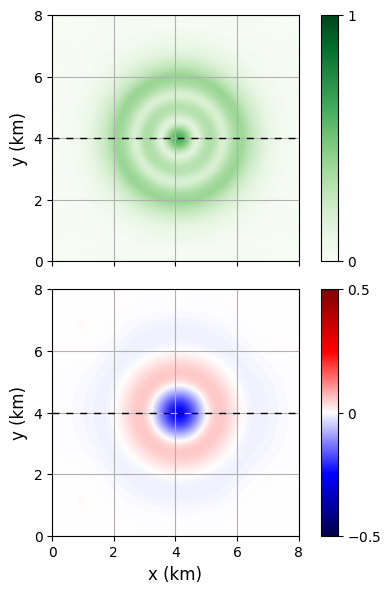

In [15]:
# Define global font size variables
fontsize = 12
fontsize_ticks = 10

# Create figure (ensure vertical span matches first figure)
fig = plt.figure(figsize=(5.6, 5.6))  # Ensure the height aligns with the first figure

### **Manually Set Subplot Positions to EXACTLY Match First Figure**
bottom_margin = 0.04  # Keep consistent with the first figure
top_limit = 0.97  # Keep consistent with the first figure
gap_between_panels = 0.05  # Ensure spacing consistency

# **Calculate Panel Heights (Exactly Matching the First Figure)**
panel_height = (top_limit - bottom_margin - gap_between_panels) / 2  # Match left-side figure
panel_width = panel_height  # Ensure square aspect ratio

# **Exact positioning to align with the first figure**
ax1_bottom = bottom_margin + panel_height + gap_between_panels  # Align top panel
ax2_bottom = bottom_margin  # Align bottom panel

# **Manually set positions to ensure alignment**
ax1 = fig.add_axes([0.1, ax1_bottom, panel_width, panel_height])  # Top subplot
ax2 = fig.add_axes([0.1, ax2_bottom, panel_width, panel_height])  # Bottom subplot

####### **TOP PLOT (PLASTIC DAMAGE - κ FIELD)** #######
im1 = tripcolor(γ, axes=ax1, cmap='Greens', vmin=0, vmax=K * valve_thresh)

ax1.set_ylabel('y (km)', fontsize=fontsize)
ax1.set_xticks(range(0, 9000, 2000))  
ax1.set_xticklabels([])  # Remove x-axis labels but retain ticks for grid alignment
ax1.set_yticks(range(0, 9000, 2000))
ax1.set_yticklabels(range(0, 9, 2), fontsize=fontsize_ticks)
ax1.set_xlim(0, 8000)  
ax1.set_ylim(0, 8000)  
ax1.grid()

# **Move Colorbar Closer & Ensure Alignment**
cax1 = fig.add_axes([0.77, ax1_bottom, 0.03, panel_height])  
cbar1 = fig.colorbar(im1, cax=cax1, ticks=[0, 1])
cbar1.ax.set_yticklabels(['0', '1'], fontsize=fontsize_ticks)  # Remove label

####### **BOTTOM PLOT (NET DEFLECTION - η FIELD)** #######
im2 = tripcolor(η, axes=ax2, cmap='seismic', vmin=-1/2, vmax=1/2)

ax2.set_xlabel('x (km)', fontsize=fontsize)
ax2.set_ylabel('y (km)', fontsize=fontsize)
ax2.set_xticks(range(0, 9000, 2000))
ax2.set_xticklabels(range(0, 9, 2), fontsize=fontsize_ticks)
ax2.set_yticks(range(0, 9000, 2000))
ax2.set_yticklabels(range(0, 9, 2), fontsize=fontsize_ticks)
ax2.set_xlim(0, 8000)  
ax2.set_ylim(0, 8000)  
ax2.grid()

# **Move Colorbar Closer & Ensure Alignment**
cax2 = fig.add_axes([0.77, ax2_bottom, 0.03, panel_height])  
cbar2 = fig.colorbar(im2, cax=cax2, ticks=[-1/2, 0, 1/2])
cbar2.ax.set_yticklabels([r"$-0.5$", "0", r"$0.5$"], fontsize=fontsize_ticks)  

# **Manually Adjust Subplot Positions to Ensure Perfect Alignment**
ax1.set_position([0.1, ax1_bottom, panel_width, panel_height])
ax2.set_position([0.1, ax2_bottom, panel_width, panel_height])
cax1.set_position([0.58, ax1_bottom, 0.03, panel_height])
cax2.set_position([0.58, ax2_bottom, 0.03, panel_height])

ax1.plot([0, 8e3], [4e3, 4e3], 'k--', linewidth=1, dashes=(5, 5))
ax2.plot([0, 8e3], [4e3, 4e3], 'k--', linewidth=1, dashes=(5, 5))

# Save and show figure
plt.savefig('figure_4_EF.png')
plt.show()
